In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path to the dataset in Google Drive
file_path = '/content/drive/My Drive/Cloud/All_Beauty.csv'

Mounted at /content/drive


In [ ]:
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("BeautyDataPipeline").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first few rows of the dataset
print("Dataset loaded successfully!")
df.show(5)

# Display schema and summary statistics
print("\nDataset schema:")
df.printSchema()

print("\nNumber of rows and columns:")
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

Dataset loaded successfully!
+------+--------------------+--------------------+------+----------+-----------+--------------------+--------------------+------------+-----------------+
|rating|               title|                text|images|      asin|parent_asin|             user_id|           timestamp|helpful_vote|verified_purchase|
+------+--------------------+--------------------+------+----------+-----------+--------------------+--------------------+------------+-----------------+
|     5|Such a lovely sce...|This spray is rea...|    []|B00YQ6X8EO| B00YQ6X8EO|AGKHLEW2SOWHNMFQI...|2020-05-05 14:08:...|           0|             True|
|     4|Works great but s...|This product does...|    []|B081TJ8YS3| B081TJ8YS3|AGKHLEW2SOWHNMFQI...|2020-05-04 18:10:...|           1|             True|
|     5|                Yes!|Smells good, feel...|    []|B07PNNCSP9| B097R46CSY|AE74DYR3QUGVPZJ3P...|2020-05-16 21:41:...|           2|             True|
|     1|   Synthetic feeling|      Felt synthet

In [ ]:
# Check for null values in each column
print("\nNull values per column:")
df.select([col(c).isNull().alias(c) for c in df.columns]).show()

# Remove duplicate rows
cleaned_df = df.dropDuplicates()

# Display the first few rows of the cleaned dataset
print("\nCleaned Dataset:")
cleaned_df.show(5)

# Save the cleaned dataset to Google Drive in CSV format
output_path = '/content/drive/My Drive/Cloud/Cleaned_All_Beauty.csv'
cleaned_df.write.csv(output_path, header=True)

print(f"\nCleaned dataset saved to {output_path}")


Null values per column:
+------+-----+-----+------+-----+-----------+-------+---------+------------+-----------------+
|rating|title| text|images| asin|parent_asin|user_id|timestamp|helpful_vote|verified_purchase|
+------+-----+-----+------+-----+-----------+-------+---------+------------+-----------------+
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| false|false|      false|  false|    false|       false|            false|
| false|false|false| fals

In [ ]:
# Path to the cleaned dataset
cleaned_file_path = '/content/drive/My Drive/Cloud/Cleaned_All_Beauty.csv'

# Load the cleaned CSV into a Spark DataFrame
cleaned_df = spark.read.csv(cleaned_file_path, header=True, inferSchema=True)

# Verify data loading
cleaned_df.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+
|rating|               title|                text|              images|                asin|         parent_asin|             user_id|           timestamp|       helpful_vote|verified_purchase|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+
|     5|     these are great|well, I love the ...|                  []|          B00DR75MOM|          B00DR75MOM|AGQFGXUGFSZHNRQGP...|2015-01-01 01:09:...|                  1|             True|
|     3|            warm hat|Sorta dumb lookin...|                  []|          B008CPAQUE|          B008CPAQUE|AGYU3KLQWZIUYKAXV...|2015-02-10 18:50:...|                  0|             True|
|     4|excellent ingredi...|"

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum

# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("Data Aggregation").getOrCreate()

# Step 2: Load the Dataset
file_path = "/content/drive/My Drive/Cloud/Cleaned_All_Beauty.csv"  # Replace with your actual path
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Check and Convert 'helpful_vote' to Numeric
data = data.withColumn(
    'helpful_vote',
    when(col('helpful_vote').cast('int').isNotNull(), col('helpful_vote').cast('int')).otherwise(0)
)

# Step 4: Separate Verified and Unverified Reviews
verified_reviews = data.filter(data['verified_purchase'] == True)
unverified_reviews = data.filter(data['verified_purchase'] == False)

# Step 5: Group by Rating and Aggregate Helpful Votes
verified_votes = verified_reviews.groupBy('rating').agg(sum('helpful_vote').alias('helpful_vote_verified'))
unverified_votes = unverified_reviews.groupBy('rating').agg(sum('helpful_vote').alias('helpful_vote_unverified'))

# Step 6: Combine Verified and Unverified Votes
combined_votes = verified_votes.join(
    unverified_votes,
    on='rating',
    how='outer'
).fillna(0)

# Step 7: Add Total and Percentages
combined_votes = combined_votes.withColumn(
    "helpful_vote_total",
    col("helpful_vote_verified") + col("helpful_vote_unverified")
).withColumn(
    "percent_verified",
    (col("helpful_vote_verified") / col("helpful_vote_total") * 100).cast("float")
).withColumn(
    "percent_unverified",
    (col("helpful_vote_unverified") / col("helpful_vote_total") * 100).cast("float")
)

# Step 8: Show Results
combined_votes.show(truncate=False)

# Step 9: Save Processed Data
output_path = "/content/drive/My Drive/Cloud/processed_votes.csv"  # Replace with desired path
combined_votes.write.csv(output_path, header=True, mode="overwrite")
print(f"Processed data saved successfully to: {output_path}")

+------+---------------------+-----------------------+------------------+----------------+------------------+
|rating|helpful_vote_verified|helpful_vote_unverified|helpful_vote_total|percent_verified|percent_unverified|
+------+---------------------+-----------------------+------------------+----------------+------------------+
|1     |82050                |12138                  |94188             |87.11301        |12.8869915        |
|2     |27402                |3058                   |30460             |89.9606         |10.039396         |
|3     |35239                |3918                   |39157             |89.994125       |10.005874         |
|4     |60550                |8995                   |69545             |87.065926       |12.934072         |
|5     |350602               |36799                  |387401            |90.50106        |9.498943          |
+------+---------------------+-----------------------+------------------+----------------+------------------+

Processed

In [ ]:
import pandas as pd
from tabulate import tabulate

# Path to the file
processed_data_path = "/content/drive/My Drive/Cloud/processed_votes.csv/part-00000-2bb7bdd7-745a-4f7f-86f3-6801c6f57279-c000.csv"

# Load the processed data
processed_data = pd.read_csv(processed_data_path, header=0)

# Display a preview of the data in a table format with solid borders
print("\nProcessed Data Preview:")
print(tabulate(processed_data.head(), headers='keys', tablefmt='mixed_grid', showindex=False))

# Check for missing values
missing_values = processed_data.isnull().sum()  # Calculate missing values for each column
missing_values_df = missing_values.reset_index()  # Convert to DataFrame
missing_values_df.columns = ['Column', 'Missing Values']  # Rename columns

print("\nMissing Values:")
print(tabulate(missing_values_df, headers='keys', tablefmt='mixed_grid'))

# Validate totals
if 'helpful_vote_verified' in processed_data.columns and 'helpful_vote_unverified' in processed_data.columns:
    # Calculate total votes
    processed_data['calculated_total'] = (
        processed_data['helpful_vote_verified'] + processed_data['helpful_vote_unverified']
    )

    # Prepare validation data
    validation_data = processed_data[['helpful_vote_total', 'calculated_total']].head()

    print("\nValidation:")
    print(tabulate(validation_data, headers='keys', tablefmt='mixed_grid', showindex=False))
else:
    print("\nValidation columns not found in the dataset.")



Processed Data Preview:
┍━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━┑
│   rating │   helpful_vote_verified │   helpful_vote_unverified │   helpful_vote_total │   percent_verified │   percent_unverified │
┝━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━┥
│        1 │                   82050 │                     12138 │                94188 │            87.113  │             12.887   │
├──────────┼─────────────────────────┼───────────────────────────┼──────────────────────┼────────────────────┼──────────────────────┤
│        2 │                   27402 │                      3058 │                30460 │            89.9606 │             10.0394  │
├──────────┼─────────────────────────┼───────────────────────────┼──────────────────────┼────────────────────┼──────────────────────┤
│        3 │                   35239 

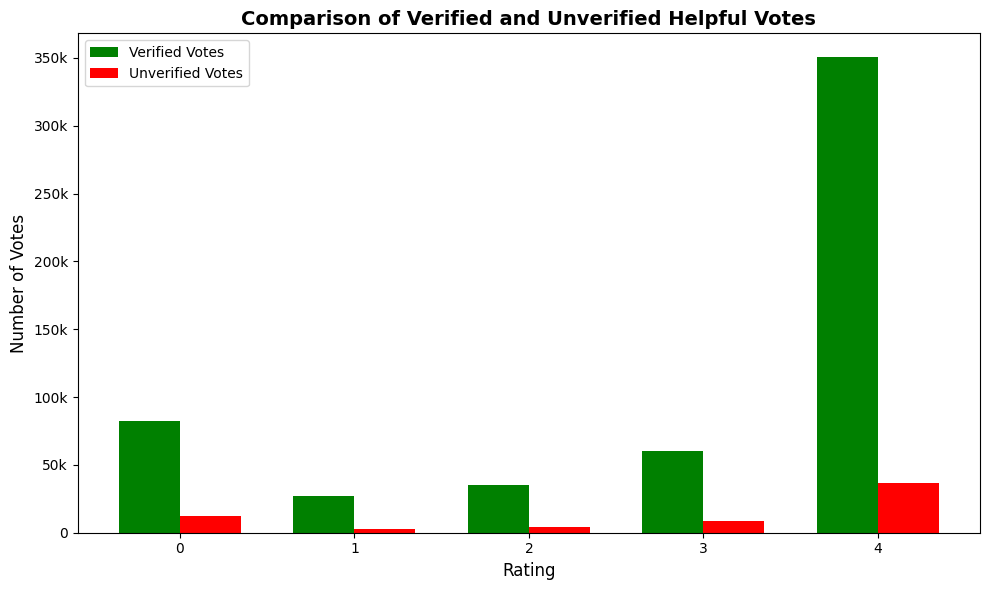

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Create a formatter function for the y-axis
def y_axis_formatter(x, pos):
    return f'{int(x/1000)}k' if x >= 1000 else str(int(x))

# Plotting the helpful votes with improved aesthetics
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(processed_data))

# Plot Verified Votes in green and Unverified Votes in red
plt.bar(index, processed_data['helpful_vote_verified'], bar_width, label='Verified Votes', color='green')
plt.bar([i + bar_width for i in index], processed_data['helpful_vote_unverified'], bar_width, label='Unverified Votes', color='red')

# Enhancing x-axis labels for clarity
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Votes', fontsize=12)
plt.title('Comparison of Verified and Unverified Helpful Votes', fontsize=14, fontweight='bold')

# Adjusting x-ticks for better readability
plt.xticks([i + bar_width / 2 for i in index], processed_data.index)

# Apply the y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Adding the legend
plt.legend()

# Tight layout to ensure nothing is cut off
plt.tight_layout()

# Save the plot to a file
plt.savefig('helpful_votes_comparison.png')

# Show the plot
plt.show()